# Adjusting the generosity of unemployment benefits over the business cycle(*)

* Janneke Horenga (541639) - [jannekehorenga](http://jannekehorenga.github.io/)
* Bart de Geus (561375) - [bartdegeus](http://bartdegeus.github.io/)

###### (*) Third assignment for the course Methods: Numerical Simulation, April 15th, 2016. We thank prof. Boone for his help on the fixed-point algorithm and numerous tips.

### Research question
What would be the effect on job-search intensity, the value of average unemployment, unemployment duration and aggregate welfare of increasing the replacement rate of unemployment benefits during a recession?

### Motivation
During the Great Recession many European economies saw steep increases in the  unemployment rate (see this [Table from OECD data](https://data.oecd.org/chart/4v74)). With job finding rates low and more long-term unemployment, governments might expand the generosity of unemployment insurance benefits to ease economic pain for the unemployed and reduce the shortfall in aggregate demand [(Moffit 2014, p.5)](http://wol.iza.org/articles/unemployment-benefits-and-unemployment.pdf). One way is to lengthen the duration of the benefit period, the effects of which have already been surveyed by [Tatsiramos and Van Ours (2012)](http://onlinelibrary.wiley.com/doi/10.1111/joes.12005/abstract). A second option for governments is to increase the benefit level during a recession, which may be more effective in keeping up aggregate demand in the short-term. Benefit levels are commonly measured by the net income replacement rate, the ratio of benefits to the recepients earnings on the terminated job [(Moffit 2014, p.3)](http://wol.iza.org/articles/unemployment-benefits-and-unemployment.pdf).

But any adjustment to the generosity of benefits must balance the improvement in welfare with expected side-effects, the most important of which is moral hazard among job-seekers. An increase in the replacement rate reduces the gains from taking a job during the benefit period and benefit recepients might lower their search effort in response. This could slow down a recovery [(Moffit 2014, p.6)](http://wol.iza.org/articles/unemployment-benefits-and-unemployment.pdf). We therefore ask what would be the effect of an increase in the replacement rate on the following labor market outcomes and welfare measures: job-search intensity, the value of unemployment, unemployment duration and aggregate welfare.

### Method
We use a two-sided search-matching model of a dynamic labor market from [Boeri and Van Ours (2013, sec 11.9)](http://press.princeton.edu/titles/10142.html), which is a simplified version of the model used by [Boone and Van Ours (2006)](http://www.ingentaconnect.com/content/mohr/jite/2006/00000162/00000002/art00001/), to simulate the overall effects of a change in the replacement rate. Our model is limited in the sense that unemployement is caused by search frictions rather than demand shortfalls. Moreover, because the model does not include a feedback loop from changes in the replacement rate to product market demand, our work here is limited to an analysis of partial equilibrium.

We look at the Dutch economy. We start with a [baseline scenario](#base) for which we normalize productivity. The baseline scenario corresponds to 2008, when real GDP growth was 1.7%. To simulate a [recession](#reces) we adjust the productivity parameter based on [data](#data) from the Netherlands during the Great Recession. We calculate the relative change in GDP per unit worked and compare labor market outcomes under both states of the business cycle. To answer our research question we increase the replacement rate of unemployment insurance benefits from $b=0.7$ to $b=0.8$ and compare steady-state labor market outcomes for the two different levels of the replacement rate.

We conduct a sensitivity analysis to determine the robustness of our results to changes in __[variables]__.

### Answer
A recession that is characterized by a 2.24 % decrease in labor productivity, an increase of the unemployment benefit replacement rate from 70% to 80% will __[Effects]__

### Main assumptions
We have made a number of assumptions.
* A labor market in equilibrium with unemployment as [modelled](#equations) in [Boeri and Van Ours (2013, sec 11.9)](http://press.princeton.edu/titles/10142.html);
* A fall in the level of labor productivity as a proxy for demand shortfall to simulate a recession;
* We take values for the [exogenous parameters](#exo) from [Boone and Van Ours (2006, p. 238-9)](http://www.ingentaconnect.com/content/mohr/jite/2006/00000162/00000002/art00001/) as an approximation of a labor market in a developed economy. We conduct a [sensitivity analysis](#sens) on  __[Variables]__;
* A [policy change](#pol) in which the unemployment benefit replacement rate is raised from 0.7 to 0.8.

Some assumptions are implicit in the model:
* Labor is homogenous and all employed workers receive the same wage;
* Wages are flexible: unemployment arises because of search frictions;
* Workers and firms are risk-neutral;
* A linear felicity function of wages;
* Workers can adjust their search effort to influence the probability of finding a job;
* Unemployment insurance benefits are one-dimenional: there is a constant replacement rate and benefits last forever;
* Labor supply is exogenous and the total labor force is set to $1$ (cf Boone and Van Ours (2006))
* Entry for firms is free: the value of creating a vacancy ($J_{\upsilon}$) is $0$

## Execution

### Importing libraries and packages

In [186]:
import math
import numpy as np
import pandas as pd
from scipy import arange, optimize
import matplotlib.pyplot as plt
%matplotlib inline

### Data<a id='data'></a>
Our values for exogenous parameters are taken from [Boone and Van Ours (2006, p. 238-9)](http://www.ingentaconnect.com/content/mohr/jite/2006/00000162/00000002/art00001/).

We adjust the exogenous parameter for the productivity level to simulate a change in business cycle conditions. We adjust on the basis of observed reductions in a proxy for productivity, real GDP per hour worked (index measure), from [OECD.Stat](http://stats.oecd.org/viewhtml.aspx?datasetcode=PDB_GR&lang=en#) for the Netherlands during the Great Recession (2008-2013). 

In [187]:
df = pd.read_csv('data.csv')

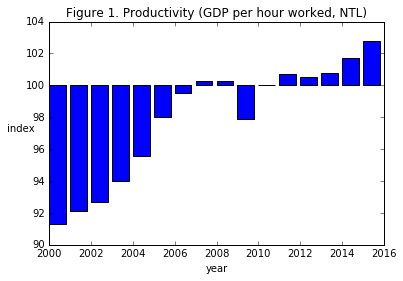

In [188]:
baseline = 100.0
plt.bar(df.year, df.value-baseline, bottom=baseline)
plt.xlabel ('year')
plt.ylabel ('index', rotation=0)
plt.title ('Figure 1. Productivity (GDP per hour worked, NTL)')
plt.savefig ('Productivity_bar.png')

### Model<a id='model'></a>

A simplified model form [Boeri and Van Ours (2013, sec 11.9)](http://press.princeton.edu/titles/10142.html).

#### Table 1. Exogenous parameters <a id='exo'></a>

|  Symbol  	| Definition       	|   	|     Symbol     	| Definition                  	|
|:--------:	|------------------	|---	|:--------------:	|-----------------------------	|
|    $b$   	| replacement rate 	|   	|     $\beta$    	| bargaining power of workers 	|
|  $\rho$  	| discount rate    	|   	|       $y$      	| productivity level          	|
| $\kappa$ 	| search cost function parameter |   	| $c_{\upsilon}$ 	| cost of opening a vacancy	|
|  $\eta$  	| matching function parameter 	|   	|    $\delta$    	| job destruction rate |
|    $A$   	| matching function parameter 	|   	| 	|                   |

In [189]:
# Exogenous parameters from Boone and Van Ours (2006)

rho = 0.025        # discount rate
kappa = 0.5        # search cost function parameter
eta = 0.5          # matching function parameter
A = 1.5            # efficiency of matching function
beta = 0.5         # bargaining power of workers
c_ups = 2.0        # cost of opening a vacancy
delta = 0.04       # job destruction rate

#### Table 2. Endogenous parameters <a id='endo'></a> (Steady state)

|     Symbol     | Definition                  |   |     Symbol    | Definition              |
|:--------------:|-----------------------------|---|:-------------:|-------------------------|
|    $\gamma$    | disutility of job-search    |   |      $u$      | unemployed (share of labor force)    |
|       $s$      | job-search effort by worker |   |      $e$      | employed (share of labor force)      |
|      $V_u$     | value of unemployment       |   |      $m$      | period job matches      |
|      $V_e$     | value of employment         |   |    $\theta$   | labor market tightness  |
|       $w$      | period wage                 |   |     $\mu$     | job finding probability |
|      $J_e$     | value of a job              |   |      $t$      | tax rate                |
| $J_{\upsilon}$ | value of a vacancy          |   |      $W$      | total welfare           |
|   $\upsilon$   | number of vacancies         |   | $\overline{u_t}$| average unemployment duration    |

In [190]:
# Restrictions on endogenous variables

J_ups = 0          # Value of vacancy bid down to 0 (cf. Boone and Van Ours (2006))

t = 0.0            # tax rate (set temporarily for finding fixed-points)

### Model equations<a id='equations'></a>

#### Optimal job search intensity 

disutility of searching $$\gamma\left(s\right)=\frac{1-\left(1-s\right)^{1-\kappa}}{1-\kappa}-s$$

with $ \gamma(0)=0$ ; $ \gamma'(0)=0$; $ \gamma'(s)>0$ ; $ \gamma''(s)>0$ ; $ \lim_{s\to 1} \gamma'(s)=+\infty $

flow value of being unemployed $$ \rho V_u = \underset{0 \le s \le 1}{max}\{bw-\gamma(s) + \mu s (V_e - V_u) \} $$

flow value of being employed

$$ \rho V_e = w + \delta \left(V_u - V_e \right) $$

#### Vacancies and the matching function

flow of matches

$$ m\left(s u,\upsilon\right) = A \left(su\right)^{1-\eta} \upsilon^{\eta} $$

search parameter for unemployed workers
$$ \mu = \frac{m \left(su, \upsilon \right)}{su} = A\theta^{\eta} $$

with $\theta=\frac{\upsilon}{su}$

flow value of a job $$ \rho J_e = y - (1+t)w + \delta ( J_{\upsilon} - J_e) $$

flow value of a vacancy

$$ \rho J_{\upsilon} = -c_{\upsilon}+\frac{\mu}{\theta}(J_e - J_{\upsilon}) $$

#### Wage bargaining

$$ \underset{w}{max}\{(V_e - V_u)^{\beta}(J_e - J_{\upsilon})^{1-\beta}\} $$

which gives $$ w = (1 - \beta) \rho V_u + \beta \frac{y}{1+t} $$

#### Labor market participation

labor market equilibrium condition $$ \mu s u = \delta e $$

labor force participation rate $$ e + u = 1 $$
Total labor force normalized to $1$

#### Balanced budget requirement

$$ etw = ubw $$

#### Total welfare

We add total welfare from [Boone and Van Ours (2006)](http://www.ingentaconnect.com/content/mohr/jite/2006/00000162/00000002/art00001/).

$$ W = uV_u + e(V_e+J_e)+\upsilon J_{\upsilon} $$

#### Average unemployment duration
Added from [Boone and Van Ours (2006, p.239)](http://www.ingentaconnect.com/content/mohr/jite/2006/00000162/00000002/art00001/).
$$\overline{u_t} = \frac{1}{\mu(\theta)}$$

### Calculations for steady states

#### Baseline scenario<a id='base'></a>
We start with a baseline scenario in which the economy is not in a recession. For this we can normalize the productivity parameter, $y=1$.

In [191]:
# State of the economy

y = 1.0            # productivity level

# Baseline value of the unemployment benefit replacement rate

b = 0.7            # replacement rate

We define those endogenous variables required to solve the model and find the other endogenous variables for our comparison of steady states.

In [192]:
# disutility from job search
def gamma(s):
    return ((1.0-(1.0-s)**(1.0-kappa)))/(1.0-kappa) -s

##### Finding fixed-points
We solve the model by finding a fixed point of the  value function for the unemployed worker, $V_u$. We substitute in the definition of the optimal wage from wage bargaining, $w$, and the definiton of $J_e$ and $\theta$.

In [193]:
def fixed_point(v_u):
    w = (1.0-beta)*rho*v_u + beta * (y/(1.0+t))
    J_e = (y-(1.0+t)*w)/(rho+delta)
    theta = ((A*J_e)/(c_ups))**(1.0/(1.0-eta))
    # find optimal s for given values of theta and v_u    
    s_max = optimize.fminbound(lambda s: -(b*w - gamma(s) + A*(theta**eta)*s*(w/(rho+delta) - rho/(rho+delta)*v_u)),0,1,disp=1)
    output = (b*w - gamma(s_max) + A*(theta**eta)*s_max*(w/(rho+delta) - rho/(rho+delta)*v_u))/rho
    return output - v_u

In [194]:
V_u = optimize.fsolve(fixed_point, 5.0)
V_u

array([ 36.13974892])

##### Finding values for endogenous variables

For completeness, we report to following formulas to find the steady state values of the endogenous variables:

$$V_e = \frac{w + \delta V_u}{\rho+\delta} $$
$$u = \frac{\delta}{\mu s + \delta} $$
$$t = \frac{ubw}{ew} $$
$$m(su,\upsilon) = suA\theta^{\eta} $$
$$\upsilon = (\frac{m}{A(su)^{1-\eta}})^\frac{1}{\eta} $$

We assume the other values can readily be derived from the [model](#equations). 

In [195]:
# endogenous variables (order of formulas is important)
w = (1.0-beta)*rho*V_u + beta * (y/(1.0+t))
J_e = (y-(1.0+t)*w)/(rho+delta)
theta = ((A*J_e)/(c_ups))**(1.0/(1.0-eta))
s = optimize.fminbound(lambda s: -(b*w - gamma(s) + A*(theta**eta)*s*(w/(rho+delta) - rho/(rho+delta)*V_u)),0,1,disp=1)
gamma = ((1.0-(1-s)**(1-kappa)))/(1-kappa) - s
mu = A*(theta**eta)
V_e = (w + delta*V_u)/(rho+delta)
u = delta/(mu*s + delta)
e = 1 - u
t = (u*b*w)/(e*w)
m = s*u*A*(theta**eta)
upsilon = (m/(A*(s*u)**(1-eta)))**(1/eta)
W = u*V_u + e*(V_e + J_e) # note: total value of vacancies is zero
u_t = 1/mu

In [196]:
# Create table for results.
endo_varnames = ["V_u","w","J_e","theta","s","gamma","mu","V_e","u","e","t","m","upsilon","W","u_t"]
endo_val_baseline = [V_u,w,J_e,theta,s,gamma,mu,V_e,u,e,t,m,upsilon,W,u_t]
for index, item in enumerate(endo_val_baseline):
    endo_val_baseline[index] = round(float(item),3)
table = dict(zip(endo_varnames, endo_val_baseline))

In [197]:
print "{:<8} {:^25}".format('Variable','Baseline:y=1.0 & b=0.7')
for k, v in table.iteritems():
    print "{:<8} {:^25}".format(k, v)

Variable  Baseline:y=1.0 & b=0.7  
V_u                36.14          
e                  0.928          
J_e                0.742          
W                 37.518          
u_t                1.197          
m                  0.037          
mu                 0.835          
V_e               36.882          
s                  0.619          
u                  0.072          
t                  0.054          
w                  0.952          
upsilon            0.014          
theta              0.31           
gamma              0.146          


We will hold off on presenting the baseline in a graph until the next section to enable comparison.

#### A recession<a id='reces'></a>
As a final step before we introduce our policy change, we compare the baseline scenario with the recession. The OECD [data](#data) shows a decline in productivity in the Netherlands during the beginning of the recession. We compare the baseline scenario of 2008 to productivity in 2009 for maximum effect. Below we caculate the productivity variable $y_{low} = 0.976$

In [198]:
b = 0.7 # We keep the replacement rate constant

# lowest productivity during recession
y_low = df.value[9]/df.value[8]
y_low

0.97607178464606192

We again solve the model for the endogenous variables in this steady state.

In [199]:
# find fixed point
t = 0.0

def gamma(s):
    return ((1.0-(1.0-s)**(1.0-kappa)))/(1.0-kappa) -s

def fixed_point(v_u):
    w = (1.0-beta)*rho*v_u + beta * (y_low/(1.0+t))
    J_e = (y_low-(1.0+t)*w)/(rho+delta)
    theta = ((A*J_e)/(c_ups))**(1.0/(1.0-eta))
    # find optimal s for given values of theta and v_u    
    s_max = optimize.fminbound(lambda s: -(b*w - gamma(s) + A*(theta**eta)*s*(w/(rho+delta) - rho/(rho+delta)*v_u)),0,1,disp=1)
    output = (b*w - gamma(s_max) + A*(theta**eta)*s_max*(w/(rho+delta) - rho/(rho+delta)*v_u))/rho
    return output - v_u

In [200]:
V_u = optimize.fsolve(fixed_point, 5.0)
V_u

array([ 35.2162615])

In [201]:
# endogenous variables
w = (1.0-beta)*rho*V_u + beta * (y/(1.0+t))
J_e = (y-(1.0+t)*w)/(rho+delta)
theta = ((A*J_e)/(c_ups))**(1.0/(1.0-eta))
s_max = optimize.fminbound(lambda s: -(b*w - gamma(s) + A*(theta**eta)*s*(w/(rho+delta) - rho/(rho+delta)*V_u)),0,1,disp=1)
gamma = ((1.0-(1-s_max)**(1-kappa)))/(1-kappa) - s_max
mu = A*(theta**eta)
V_e = (w + delta*V_u)/(rho+delta)
u = delta/(mu*s_max + delta)
e = 1 - u
t = (u*b*w)/(e*w)
m = s_max*u*A*(theta**eta)
upsilon = (m/(A*(s_max*u)**(1-eta)))**(1/eta)
W = u*V_u + e*(V_e + J_e) # note: total value of vacancies is zero
u_t = 1/mu

In [202]:
# Create table for results.
endo_val_recession = [V_u,w,J_e,theta,s,gamma,mu,V_e,u,e,t,m,upsilon,W,u_t]
for index, item in enumerate(endo_val_recession):
    endo_val_recession[index] = round(float(item),3)
table = dict(zip(endo_varnames, endo_val_recession))

In [203]:
print "{:<8} {:^25}".format('Variable','Recession:y=0.976 & b=0.7')
for k, v in table.iteritems():
    print "{:<8} {:^25}".format(k, v)

Variable Recession:y=0.976 & b=0.7
V_u               35.216          
e                  0.95           
J_e                0.92           
W                 36.965          
u_t                0.966          
m                  0.038          
mu                 1.035          
V_e               36.136          
s                  0.619          
u                  0.05           
t                  0.037          
w                  0.94           
upsilon            0.017          
theta              0.476          
gamma              0.238          


In Table 3 below we present our intermediate results of simulations for steady states over the business cycle.

__Table 3. Comparison of steady states over the business cycle with constant policy__

| Variable   | Baseline y = 1.0 & b = 0.7 | Recession y = 0.976 & b = 0.7  |
|------------|:--------------------------:|:------------------------------:|
| $V_u$      |           34.348           |             33.361             |
| $w$        |            0.905           |              0.891             |
| $J_e$      |            0.749           |              0.927             |
| $\theta$   |            0.316           |              0.483             |
| $s$        |            0.61            |              0.61              |
| $\gamma$   |            0.141           |              0.229             |
| $\mu$      |            0.843           |              1.043             |
| $V_e$      |           35.061           |              34.24             |
| $u$        |            0.072           |              0.05              |
| $e$        |            0.928           |              0.95              |
| $t$        |            0.055           |              0.037             |
| $m$        |            0.037           |              0.038             |
| $\upsilon$ |            0.014           |              0.018             |
| $W$        |           35.704           |             35.077             |
| $u_t$      |            1.187           |              0.959             |

#### Policy change: a higher replacement rate during recession<a id='pol'></a>

We set b = 0.8, an increase of 10 %pt, or a raise of about 14.3%

In [121]:
b = 0.8 # We adjust the replacement rate

y_low # We keep the economy in recession

0.97607178464606192

We again solve the model for the endogenous variables in the new steady state.

In [170]:
# find fixed point
t = 0.0

def gamma(s):
    return ((1.0-(1.0-s)**(1.0-kappa)))/(1.0-kappa) -s

def fixed_point(v_u):
    w = (1.0-beta)*rho*v_u + beta * (y_low/(1.0+t))
    J_e = (y_low-(1.0+t)*w)/(rho+delta)
    theta = ((A*J_e)/(c_ups))**(1.0/(1.0-eta))
    # find optimal s for given values of theta and v_u    
    s_max = optimize.fminbound(lambda s: -(b*w - gamma(s) + A*(theta**eta)*s*(w/(rho+delta) - rho/(rho+delta)*v_u)),0,1,disp=1)
    output = (b*w - gamma(s_max) + A*(theta**eta)*s_max*(w/(rho+delta) - rho/(rho+delta)*v_u))/rho
    return output - v_u

In [171]:
V_u = optimize.fsolve(fixed_point, 5.0)
V_u

array([ 35.2162615])

In [172]:
# endogenous variables
w = (1.0-beta)*rho*V_u + beta * (y/(1.0+t))
J_e = (y-(1.0+t)*w)/(rho+delta)
theta = ((A*J_e)/(c_ups))**(1.0/(1.0-eta))
s_max = optimize.fminbound(lambda s: -(b*w - gamma(s) + A*(theta**eta)*s*(w/(rho+delta) - rho/(rho+delta)*V_u)),0,1,disp=1)
gamma = ((1.0-(1-s_max)**(1-kappa)))/(1-kappa) - s_max
mu = A*(theta**eta)
V_e = (w + delta*V_u)/(rho+delta)
u = delta/(mu*s_max + delta)
e = 1 - u
t = (u*b*w)/(e*w)
m = s_max*u*A*(theta**eta)
upsilon = (m/(A*(s_max*u)**(1-eta)))**(1/eta)
W = u*V_u + e*(V_e + J_e) # note: total value of vacancies is zero
u_t = 1/mu

In [173]:
# Create table for results.
endo_val_policy = [V_u,w,J_e,theta,s,gamma,mu,V_e,u,e,t,m,upsilon,W,u_t]
for index, item in enumerate(endo_val_policy):
    endo_val_policy[index] = round(float(item),3)
table = dict(zip(endo_varnames, endo_val_policy))

In [174]:
print "{:<8} {:^25}".format('Variable','Policy change:y=0.976 & b=0.8')
for k, v in table.iteritems():
    print "{:<8} {:^25}".format(k, v)

Variable Policy change:y=0.976 & b=0.8
V_u               35.216          
e                  0.95           
J_e                0.92           
W                 36.965          
u_t                0.966          
m                  0.038          
mu                 1.035          
V_e               36.136          
s                  0.619          
u                  0.05           
t                  0.037          
w                  0.94           
upsilon            0.017          
theta              0.476          
gamma              0.238          


## Results

| Variable   | Baseline y = 1.0 & b = 0.7 | Recession y = 0.976 & b = 0.7  | Policy change y = 0.976 & b = 0.8 |
|------------|:--------------------------:|:------------------------------:|:---------------------------------:|
| $V_u$      |           34.348           |             33.361             |               34.423              |
| $w$        |            0.905           |              0.891             |               0.912               |
| $J_e$      |            0.749           |              0.927             |               0.828               |
| $\theta$   |            0.316           |              0.483             |               0.386               |
| $s$        |            0.61            |              0.61              |                0.61               |
| $\gamma$   |            0.141           |              0.229             |               0.182               |
| $\mu$      |            0.843           |              1.043             |               0.932               |
| $V_e$      |           35.061           |              34.24             |               35.222              |
| $u$        |            0.072           |              0.05              |                0.06               |
| $e$        |            0.928           |              0.95              |                0.94               |
| $t$        |            0.055           |              0.037             |               0.051               |
| $m$        |            0.037           |              0.038             |               0.038               |
| $\upsilon$ |            0.014           |              0.018             |               0.016               |
| $W$        |           35.704           |             35.077             |               35.952              |
| $u_t$      |            1.187           |              0.959             |               1.073               |

__[Four graphs in one field of W,u,s,V_u on b for y=1 and y =0.9x]__

__[analysis]__

### Sensitivity analysis<a id='sens'></a>
On A and/or rho?
Take drastic recession, e.g. Spain or Greece?

__[Work]__

## Conclusion and discussion of results

The are two major limitations. We have conducted a partial-equilibrium analysis of the effects of an increase in the replacement rate of unemployment benefits on labor market outcomes. Since our model does not include feedback effects from higher unemployment benefits via aggregate demand to demand for labor, we consider our results to be a worst-case scenario. Most likely, the higher unemployment benefits will result in a positive feedback on labor productivity, ultimately leading to a higher employment rate. Similarly, we have abstracted from labor supply decisions.



__[More on results]__
